In [1]:
import numpy as np
import os
import time
import corner
import astropy.io.fits as fits

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

from astropy.visualization import SqrtStretch, imshow_norm, LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
import astropy.units as u
from astropy.wcs import WCS
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.LensModel.Profiles.spep import SPEP
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.Sampling.parameters import Param
import lenstronomy.Util.param_util as param_util
import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
from lenstronomy.Util import kernel_util
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
import matplotlib.pylab as pylab
import pandas as pd
import corner
from scipy.stats import pearson3, skew
from scipy.integrate import quad
from astropy.constants import c
from tqdm import tqdm
import h5py
import emcee

plt.style.use("science")
params = {'legend.fontsize': '25',
          'figure.figsize': (10, 10),
         'axes.labelsize': '25',
         'axes.titlesize':'25',
         'xtick.labelsize':'25',
         'ytick.labelsize':'25'}
pylab.rcParams.update(params)


In [2]:
import lenstronomy
assert lenstronomy.__version__ ==  "1.8.1"

In [3]:
SNR = 5.098 # known from original fits file
sky_zero_point = -21.1 # mag
photflam = 6.9548454E-20 # inverse sensitivity ergs/cm2/Ang/electron
galfit_data = fits.open("../data/blocks1.fits")
im = galfit_data[3].data
wcs= WCS(galfit_data[1].header)
psf = fits.open("../data/rxj1131_psf1.fits")[0].data
psf2 = fits.open("../data/tiny_psf00_psf.fits")[0].data
noise_map = fits.open("../data/rxj1131_cutout_noise_map.fits")[0].data
im[im < 0] = 0
image_principales = np.loadtxt("../data/images_positions.txt")[:4] ## B, A, C, D, G, S
f_vega = 8.60e-10
exptime = 1980
image_principales

array([[ 35.63010753, 101.14992219],
       [ 36.31652519,  71.48420782],
       [ 51.11519003,  43.54091825],
       [114.24860757,  93.42748215]])

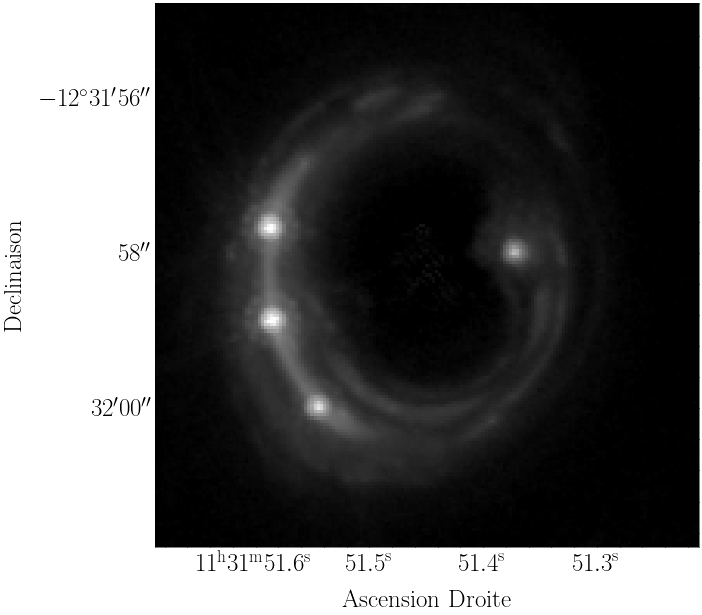

In [4]:
plt.figure(figsize=(10, 10))
plt.subplot(projection=wcs)
plt.imshow(im, cmap="gray", norm=ImageNormalize(stretch=LogStretch()))#, norm=ImageNormalize(stretch=SqrtStretch()))
ax = plt.gca()
ax.set_xlabel('Ascension Droite')
ax.set_ylabel('Declinaison');

In [73]:
# coordinate system in arcseconds, centered
N, M = im.shape
y = np.arange(N) #- N//2. + 0.5 * ((N + 1) % 2)
x = np.arange(M) #- M//2. + 0.5 * ((M + 1) % 2)
x, y = np.meshgrid(x, y)
lens_sky = wcs.pixel_to_world(x.ravel(), y.ravel())
x_center = (lens_sky.ra[M//2]).to(u.arcsec)
y_center = (lens_sky.dec[M*N//2]).to(u.arcsec)

x_image = image_principales[:, 0] # B, A, C, D
y_image = image_principales[:, 1]
positions = wcs.pixel_to_world(x_image, y_image)
x_image = (positions.ra - lens_sky.ra.max()).to(u.arcsec).value
y_image = (positions.dec - lens_sky.dec.min()).to(u.arcsec).value
image_position = pd.DataFrame(np.column_stack([x_image, y_image]), columns=["theta_x", "theta_y"])
image_position

,theta_x,theta_y
0,-1.460238,4.046300
1,-1.488295,2.859670
2,-2.094626,1.741904
3,-4.681721,3.737226


In [6]:
x_center.to(u.hourangle)

<Longitude 11.53095815 hourangle>

In [7]:
y_center.to(u.deg)

<Latitude -12.53285653 deg>

In [8]:
# time relative to first image (A) in order AB, BC, and BD
delta_t = pd.DataFrame(np.array([[0.5, -0.3, 92.3], [5.7, 5.5, 7.4]]).T, columns=["delta_t", "sigma"])
delta_t.to_csv("../data/time_delays.csv")
delta_t

,delta_t,sigma
0,0.5,5.7
1,-0.3,5.5
2,92.3,7.4


Text(0.5, 1.0, 'Pixels: 10523.0 / 30625')

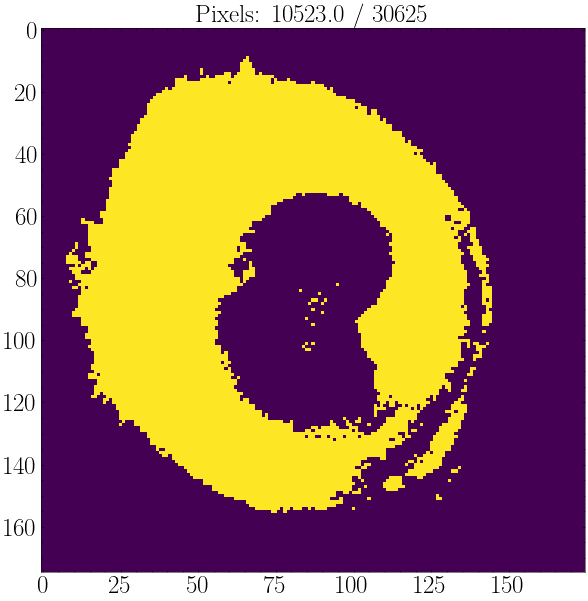

In [9]:
pixel_mask = np.ones_like(im)
pixel_mask *= im > 2 * noise_map
plt.imshow(pixel_mask)
plt.title(f"Pixels: {pixel_mask.sum()} / {M * N}")

In [10]:
# data specifics for the lens image
# sigma_bkg = .05  #  background noise per pixel (Gaussian)
# exp_time = 1.  #  exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
delta_pix_x = np.abs(lens_sky.ra[0] - lens_sky.ra[1]).to(u.arcsec).value
delta_pix_y = np.abs(lens_sky.dec[0] - lens_sky.dec[M]).to(u.arcsec).value
kwargs_data = {"image_data": im, 
#                "exposure_time": exp_time, 
#                "background_rms": sigma_bkg, 
               "noise_map": noise_map,
               "transform_pix2angle":np.array([[-delta_pix_x, 0], [0, delta_pix_y]]),
               "ra_at_xy_0": 0,
               "dec_at_xy_0": 0
               }
data_class = ImageData(**kwargs_data)

In [79]:
x = lens_sky.ra.to(u.arcsec) -  lens_sky.ra.max()
y = lens_sky.dec.to(u.arcsec) - lens_sky.dec.min()
x_center = (x[M//2]).to(u.arcsec).value
y_center = (y[M*N//2]).to(u.arcsec).value
grid = np.column_stack([x, y])
ee = 0.611 # encircled energy, source https://www.stsci.edu/hst/instrumentation/acs/data-analysis/aperture-corrections
# collect 4 pixels closest to the image position (correspond to 0.1 arcsec since pixelscale is 0.05 arcsec)
f = []
A = []
Sigma = []
k = 8
for i in range(4):
    pos = image_position.to_numpy()[i]
    diff = np.square(pos - grid.value)
    dist = np.einsum("ij -> i", diff)
    indexes = np.argpartition(dist, kth=k)[:k]
    A.append(np.sum(im.ravel()[indexes]))
    Sigma.append(np.sum(noise_map.ravel()[indexes]))
    f.append(photflam * np.sum(im.ravel()[indexes])/ee) # see e.g. https://www.stsci.edu/hst/instrumentation/acs/data-analysis/zeropoints
mag = np.array([-2.5 * np.log10(_f/f_vega) for _f in f])
Sigma = np.array(Sigma)
A = np.array(A)
measured_amplitude_ratio = A[0] / A[1:]
measured_amplitude_ratio_error = measured_amplitude_ratio * np.sqrt(Sigma[1:] ** 2 / A[1:]**2 + Sigma[0]**2 / A[0]**2)
ratios = ["BA", "BC", "BD"]
for i in range(3):
    print(f"Measured ratio {ratios[i]}: {measured_amplitude_ratio[i]:.2f} +/- {measured_amplitude_ratio_error[i]:.4f}")

Measured ratio BA: 1.17 +/- 0.0045
Measured ratio BC: 3.04 +/- 0.0160
Measured ratio BD: 11.15 +/- 0.1119


In [80]:
image_position - np.array([x_center, y_center])

,theta_x,theta_y
0,2.104722,0.566113
1,2.076665,-0.620517
2,1.470334,-1.738282
3,-1.116762,0.257039


In [12]:
kwargs_ps = [{'ra_image': x_image, 'dec_image': y_image}]
#                            'point_amp': np.abs(mag)*1000}]  
point_source_list = ['LENSED_POSITION']
# point_source_class = PointSource(point_source_type_list=point_source_list, fixed_magnification_list=[False])

In [13]:
kwargs_psf = {'psf_type': "PIXEL", "kernel_point_source":psf, "pixel_size": delta_pix_x}

In [14]:
fixed_lens = [{}, {'ra_0': x_center, 'dec_0': y_center}]
fixed_source = [{}, {}]
fixed_ps = [{}]
# initial guess of non-linear parameters, we chose different starting parameters than the truth #
kwargs_lens_init = [{'theta_E': 1.5, 'e1': 0.1, 'e2': 0.1, 'gamma': 2, 'center_x': x_center, 'center_y': y_center},
    {'gamma1': 0., 'gamma2': 0.}]
kwargs_source_init = [
                     {'R_sersic': 1, 'n_sersic': 4., 'e1': 0, 'e2': 0, 'center_x': x_center, 'center_y': y_center}, # disc
                     {'R_sersic': 1, 'n_sersic': 1., 'e1': 0., 'e2': 0., 'center_x': x_center, 'center_y': y_center} 
                     ]
# kwargs_source_init = [{'amp': 1, 'beta': 0.2, 'n_max': 7, 'center_x': x_center, 'center_y': y_center}]
kwargs_ps_init = [{'ra_image': x_image, 'dec_image': y_image}]

# initial spread in parameter estimation #
kwargs_lens_sigma = [{'theta_E': 0.3, 'e1': 0.1, 'e2': 0.1, 'gamma': .2, 'center_x': 0.1, 'center_y': 0.1},
    {'gamma1': 0.1, 'gamma2': 0.1}]
kwargs_source_sigma = [
                      {'R_sersic': 0.1, 'n_sersic': .5, 'center_x': .1, 'center_y': 0.1, 'e1': 0.2, 'e2': 0.2},
                      {'R_sersic': 0.1, 'n_sersic': .5, 'center_x': .1, 'center_y': 0.1, 'e1': 0.2, 'e2': 0.2}
                      ]
# kwargs_source_sigma = [{'amp': 0.1, 'beta': 0.2, 'n_max': 0, 'center_x': 0.2, 'center_y': 0.2}]
kwargs_ps_sigma = [{ 'ra_image': [0.02] * 4, 'dec_image': [0.02] * 4}]

# hard bound lower limit in parameter space #
kwargs_lower_lens = [{'theta_E': 0.5, 'e1': -0.5, 'e2': -0.5, 'gamma': 1.5, 'center_x': x.min().value, 'center_y': y.min().value},
    {'gamma1': -0.5, 'gamma2': -0.5}]
kwargs_lower_source = [
                      {'R_sersic': 0.04, 'n_sersic': .5, 'e1': -0.5, 'e2': -0.5, 'center_x': x_center-2, 'center_y': y_center-2},
                      {'R_sersic': 0.04, 'n_sersic': .5, 'e1': -0.5, 'e2': -0.5, 'center_x': x_center-2, 'center_y': y_center-2}
                      ]
# kwargs_lower_source = [{'amp': 0, 'beta': 0.2, 'n_max': 0, 'center_x': x.min().value, 'center_y': y.min().value}]
kwargs_lower_ps = [{'ra_image': (x_center-5) * np.ones_like(x_image), 'dec_image': (x_center-5) * np.ones_like(y_image)}]

# hard bound upper limit in parameter space #
kwargs_upper_lens = [{'theta_E': 5, 'e1': 0.5, 'e2': 0.5, 'gamma': 2.5, 'center_x': x.max().value, 'center_y': y.max().value},
    {'gamma1': 0.5, 'gamma2': 0.5}]
kwargs_upper_source = [
                      {'R_sersic': 10, 'n_sersic': 5., 'e1': 0.5, 'e2': 0.5, 'center_x': x_center+2, 'center_y': y_center+2},
                      {'R_sersic': 10, 'n_sersic': 5., 'e1': 0.5, 'e2': 0.5, 'center_x': x_center+2, 'center_y': y_center+2}
                      ]
# kwargs_upper_source = [{'amp': 10, 'beta': 100, 'n_max': 30, 'center_x': x.max().value, 'center_y': y.max().value}]
kwargs_upper_ps = [{'ra_image': (x_center+5) * np.ones_like(x_image), 'dec_image': (y_center+5) * np.ones_like(y_image)}]


lens_params = [kwargs_lens_init, kwargs_lens_sigma, fixed_lens, kwargs_lower_lens, kwargs_upper_lens]
source_params = [kwargs_source_init, kwargs_source_sigma, fixed_source, kwargs_lower_source, kwargs_upper_source]
ps_params = [kwargs_ps_init, kwargs_ps_sigma, fixed_ps, kwargs_lower_ps, kwargs_upper_ps]

In [15]:
plate_scale = (delta_pix_x + delta_pix_y)/2
plate_scale

0.04048827229965468

In [16]:
fixed_special = {}
kwargs_special_init = {}
kwargs_special_sigma = {}
kwargs_lower_special = {}
kwargs_upper_special = {}

source_size_arcsec = 0.001
# If you want to keep the source size fixed during the fitting, outcomment the line below.
fixed_special['source_size'] = source_size_arcsec
kwargs_special_init['source_size'] = source_size_arcsec
kwargs_special_sigma['source_size'] = source_size_arcsec
kwargs_lower_special['source_size'] = 0.0001
kwargs_upper_special['source_size'] = 1

kwargs_special_init['D_dt']= 5000
kwargs_special_sigma['D_dt'] = 1000
kwargs_lower_special['D_dt'] = 100
kwargs_upper_special['D_dt'] =  10000
special_params = [kwargs_special_init, kwargs_special_sigma, fixed_special, kwargs_lower_special, kwargs_upper_special]


window_size = 0.1  # units of arcseconds
grid_number = 100  # supersampled window (per axis)
kwargs_flux_compute = {'source_type': 'INF',  # you can either chose 'INF' which is a infinetesimal source sice, 'GAUSSIAN' or 'TORUS'
                       'window_size': window_size, # window size to compute the finite source magnification (only when 'GAUSSIAN' or 'TORUS' are chosen.)
                       'grid_number': grid_number} 


source_model_list = ['SERSIC_ELLIPSE']*2
# source_model_list = ["SHAPELETS"]
lens_model_list = ['SPEP', 'SHEAR']

kwargs_params = {'lens_model': lens_params,
                'source_model': source_params,
#                 'lens_light_model': lens_light_params,
                'point_source_model': ps_params,
                'special': special_params}

kwargs_model = {'lens_model_list': lens_model_list, 
#                  'lens_light_model_list': lens_light_model_list,
                'source_light_model_list': source_model_list,
                'point_source_model_list': point_source_list
                 }



In [17]:
# numerical options and fitting sequences

num_source_model = len(source_model_list)

kwargs_constraints = {
                      'joint_source_with_point_source': [[0, 0], [0, 1]], # join centroid together [i_point_source, j_source]
#                       'joint_source_with_source': [[0, 1, ["x", "y"]]], # fix centroid of the 2 sersic profile
                      'num_point_source_list': [4],
                      'solver_type': 'PROFILE_SHEAR',  # 'PROFILE', 'PROFILE_SHEAR', 'ELLIPSE', 'CENTER'
                      'Ddt_sampling': True,
#                       'source_size' : True  # explicit sampling of finite source size parameter (only use when source_type='GAUSSIAN' or 'TORUS') 
                              }

# prior_lens = [[0, 'gamma', 2, 0.1]] # [[index_model, 'param_name', mean, 1-sigma error], [...], ...]
# e.g. source size of the emission region
# prior_special = []

kwargs_likelihood = {'check_bounds': True,
                     'force_no_add_image': True,
                     'source_marg': False,
#                      'flux_ratio_likelihood' : True,
                     'check_matched_source_position': True,
                     'source_position_tolerance': plate_scale/10,
                     'time_delay_likelihood': True,
                     'image_position_likelihood': True, # evaluate point source likelihood given the measured image positions
                     'image_position_uncertainty': plate_scale,
                     "image_likelihood_mask_list" : [pixel_mask]
#                      "kwargs_flux_compute": kwargs_flux_compute
                    }
kwargs_numerics = {'supersampling_factor': 1}
image_band = [kwargs_data, kwargs_psf, kwargs_numerics]
multi_band_list = [image_band]
kwargs_data_joint = {'multi_band_list': multi_band_list, 'multi_band_type': 'single-band',
                    'time_delays_measured': delta_t["delta_t"].to_numpy(),
                    'time_delays_uncertainties': delta_t["sigma"].to_numpy(),
                    'ra_image_list': [x_image], 'dec_image_list': [y_image],
#                     'flux_ratios': measured_amplitude_ratio, 
#                      'flux_ratio_errors': measured_amplitude_ratio_error,
                    }

from lenstronomy.Workflow.fitting_sequence import FittingSequence
fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params, mpi=False)

fitting_kwargs_list = [
#         ['PSO', {'n_particles': 10, 'n_iterations': 10}],
#         ['MCMC', {'n_burn': 0, 'n_run': 20, 'walkerRatio': 5, sigma_scale=.2}] # reduce spread over new starting point
        ['PSO', {'n_particles': 100, 'n_iterations': 1000}],
        ['MCMC', {'n_burn': 0, 'n_run': 8000, 'walkerRatio': 5, "sigma_scale":.2}]
#         ['nested_sampling', {"sampler_type": "DYNESTY"}]
]

start_time = time.time()
chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()
end_time = time.time()
print(end_time - start_time, 'total time needed for computation')
print('============ CONGRATULATION, YOUR JOB WAS SUCCESSFUL ================ ')

/home/alexandre/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Computing the PSO ...


/home/alexandre/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
Converged after 544 iterations!
Best fit found:  -186002.5532680408 [2.066666297724577, -0.0881865230591187, -0.03524215438227889, 0.10507452090322034, 0.5616444813289236, 0.10099812800354079, -0.058335551728041994, 0.8405162399947006, 0.5000011874616995, 0.15545941389086948, -0.335704409617663, -1.5091805839757328, -1.5403429402690991, -2.1445141010957567, -4.73295372386675, 4.071225441535413, 2.8877897998719275, 1.7695365606152917, 3.7644582156565813, 1565.2975494746784]
-35.402084748389946 reduced X^2 of best position
-186002.5532680408 logL
10508.0 effective number of data points
[{'theta_E': 1.872581300312276, 'gamma': 2.066666297724577, 'e1': 0.03306646725141389, 'e2': -0.027870844510578537, 'center_x': -3.6595772706616208, 'center_y': 3.4572570514738827}, {'gamma1': -0.087608

  0%|          | 0/8000 [00:00<?, ?it/s]/home/alexandre/anaconda3/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 8000/8000 [2:31:33<00:00,  1.14s/it]  

Computing the MCMC...
Number of walkers =  100
Burn-in iterations:  0
Sampling iterations (in current run): 8000
9093.987205266953 time taken for MCMC sampling
9841.25401878357 total time needed for computation
============ CONGRATULATION, YOUR JOB WAS SUCCESSFUL ================ 


/home/alexandre/Desktop/Projects/lenstronomy/lenstronomy/Plots/plot_util.py:199: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("gist_heat"))
  cmap.set_bad(color='k', alpha=1.)
/home/alexandre/Desktop/Projects/lenstronomy/lenstronomy/Plots/plot_util.py:200: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("gist_heat"))
  cmap.set_under('k')
/home/alexandre/Desktop/Projects/lenstronomy/lenstronomy/Plots/model_band_plot.py:82: RuntimeWarning: divide by zero encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',


-12.371081387939274 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  12.371081387939276


/home/alexandre/Desktop/Projects/lenstronomy/lenstronomy/Plots/model_band_plot.py:547: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()
/home/alexandre/Desktop/Projects/lenstronomy/lenstronomy/Plots/model_band_plot.py:490: RuntimeWarning: divide by zero encountered in log10
  im = ax.matshow(np.log10(model), origin='lower', vmin=v_min, vmax=v_max,


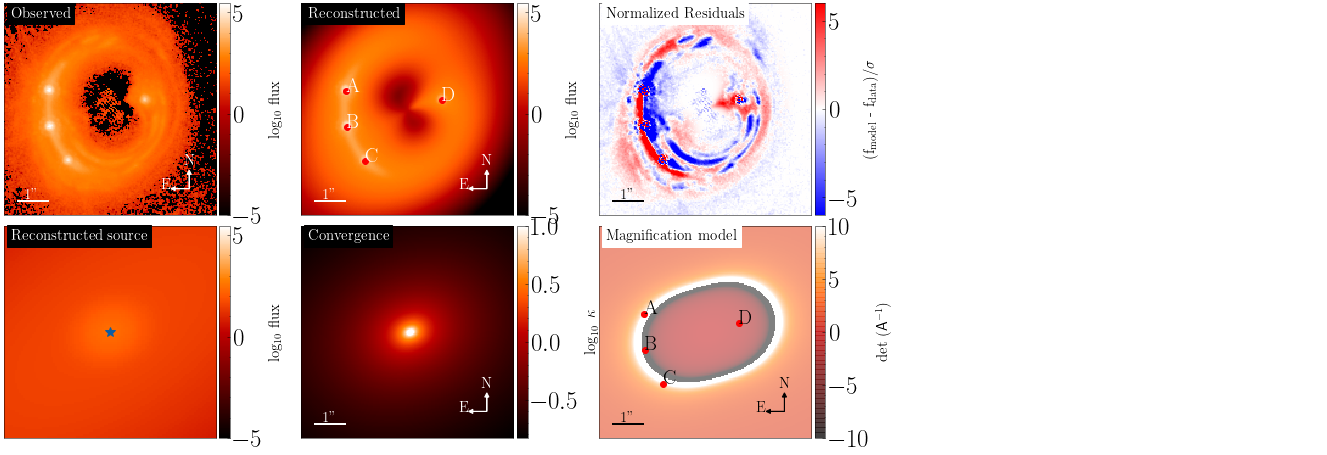

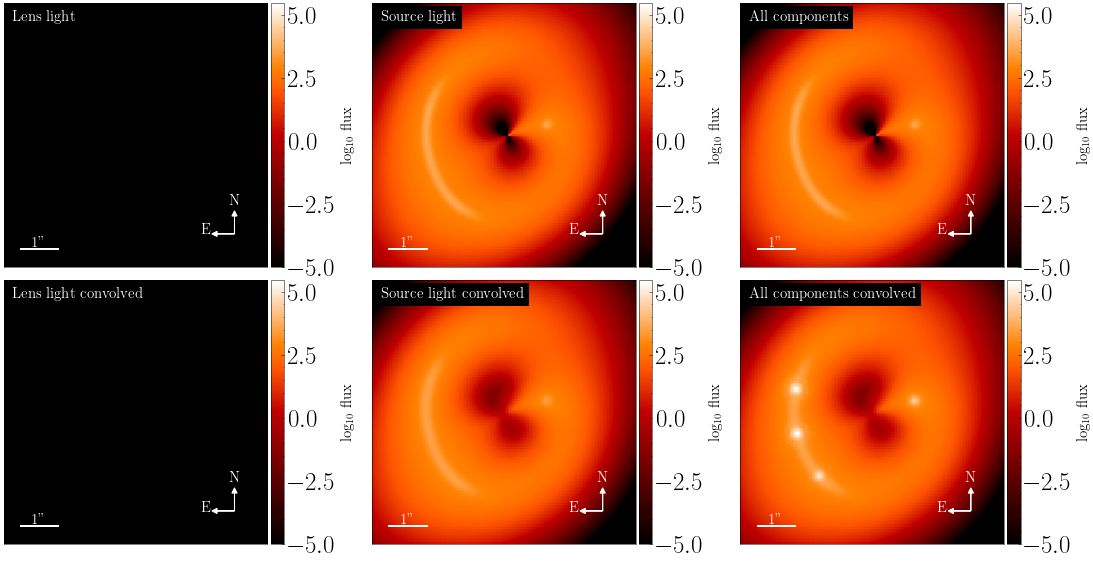

In [18]:
from lenstronomy.Plots import chain_plot
from lenstronomy.Plots.model_plot import ModelPlot

modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result, arrow_size=0.02, cmap_string="gist_heat")
    
f, axes = modelPlot.plot_main()
# f.show()
f, axes = modelPlot.plot_separate()
# f.show()
# f, axes = modelPlot.plot_subtract_from_data_all()
# f.show()


In [19]:
print(kwargs_result)

{'kwargs_lens': [{'theta_E': 1.872443304071237, 'gamma': 2.06302379016275, 'e1': 0.032887359449567874, 'e2': -0.027754525790756646, 'center_x': -3.6592932045354964, 'center_y': 3.4571529529712683}, {'gamma1': -0.08723554513837378, 'gamma2': 0.03644514137435621, 'ra_0': -3.5649596001021564, 'dec_0': 3.480186528424383}], 'kwargs_source': [{'amp': 1042832.7121931618, 'R_sersic': 0.1045741462335782, 'n_sersic': 0.5662837093713669, 'e1': 0.10148948866512471, 'e2': -0.05641537546816284, 'center_x': -3.0610707809908515, 'center_y': 3.297415446656189}, {'amp': 227870.16078718126, 'R_sersic': 0.8353691137745145, 'n_sersic': 0.500089016516581, 'e1': 0.15442748550874727, 'e2': -0.3338706125611177, 'center_x': -3.0610707809908515, 'center_y': 3.297415446656189}], 'kwargs_lens_light': [], 'kwargs_ps': [{'ra_image': array([-1.50917599, -1.5403414 , -2.14451272, -4.73300734]), 'dec_image': array([4.07125222, 2.88779223, 1.76953178, 3.76443409]), 'point_amp': array([3010463.91170054, 3307712.0466723 ,

In [20]:
from lenstronomy.Analysis.td_cosmography import TDCosmography
from astropy.cosmology import Planck15 as cosmo
z_lens = 0.295
z_source = 0.658
td_cosmo = TDCosmography(z_lens, z_source, kwargs_model, cosmo_fiducial=cosmo)

In [60]:
labels_special = [
    r"$\Delta\Psi^{\mathrm{BA}}_{\mathrm{Fermat}}$", 
    r"$\Delta\Psi^{\mathrm{BC}}_{\mathrm{Fermat}}$",
    r"$\Delta\Psi^{\mathrm{BD}}_{\mathrm{Fermat}}$",
    r"$D_{\Delta t}^{\text{modèle}}$"
                 ]
lens_labels = [
    r"$\theta_E$", 
    r"$\gamma'$",
    r"$q$",
    r"$\phi$",
    r"$\theta_{x,0}$",
    r"$\theta_{y,0}$",
    r"$\phi_{\mathrm{ext}}$",
    r"$\gamma_{\mathrm{ext}}$"
]

source_labels = [
    r"$R_e$",
    r"$n$",
    r"$q$",
    r"$\phi$"
]



In [22]:
lens_model = LensModel(["SPEP", "SHEAR"])
point_source_model = PointSource(["LENSED_POSITION"], lens_model)

In [23]:
sampler_type, samples_mcmc, param_mcmc, dist_mcmc  = chain_list[1]

print("number of non-linear parameters in the MCMC process: ", len(param_mcmc))
print("parameters in order: ", param_mcmc)
print("number of evaluations in the MCMC process: ", np.shape(samples_mcmc)[0])

# make instance of parameter class with given model options, constraints and fixed parameters #

param = Param(kwargs_model, fixed_lens, None, fixed_source, fixed_ps, fixed_special, 
              kwargs_lens_init=kwargs_result['kwargs_lens'], **kwargs_constraints)
# the number of non-linear parameters and their names #
num_param, param_list = param.num_param()

lens_params_new_list = []
special_list = []
source_params_new_list = []
point_source_new_list = []

# labels_new = [r"$\phi_{Fermat}$", r"$\gamma_1$", r"$\gamma_2$", r"$D_{\Delta t}$"]
for i in tqdm(range(len(samples_mcmc))):
    # transform the parameter position of the MCMC chain in a lenstronomy convention with keyword arguments #
    kwargs_result = param.args2kwargs(samples_mcmc[i])
    
    #special
    D_dt = kwargs_result['kwargs_special']['D_dt']
    fermat_pot = td_cosmo.fermat_potential(kwargs_result['kwargs_lens'], kwargs_result['kwargs_ps'])
    delta_fermat_BA = fermat_pot[1] - fermat_pot[0]
    delta_fermat_BC = fermat_pot[2] - fermat_pot[0]
    delta_fermat_BD = fermat_pot[3] - fermat_pot[0]
    special_list.append([delta_fermat_BA, delta_fermat_BC, delta_fermat_BD, D_dt])

    # Lens
    gamma1, gamma2 = kwargs_result['kwargs_lens'][1]['gamma1'], kwargs_result['kwargs_lens'][1]['gamma2']
    phi_ext, gamma_ext = param_util.shear_cartesian2polar(gamma1, gamma2)
    gamma = kwargs_result["kwargs_lens"][0]["gamma"]
    theta_E = kwargs_result["kwargs_lens"][0]["theta_E"]
    e1, e2 = kwargs_result["kwargs_lens"][0]["e2"], kwargs_result["kwargs_lens"][0]["e1"]
    phi, q = param_util.ellipticity2phi_q(e1, e2)
    x0, y0 = kwargs_result["kwargs_lens"][0]["center_x"], kwargs_result["kwargs_lens"][0]["center_y"]
    lens_params_new_list.append([theta_E, gamma, q, phi, x0, y0, gamma_ext, phi_ext])
    
    # Source (Disk = 0, Bulb = 1)
    R_disc = kwargs_result['kwargs_source'][0]["R_sersic"]
    n_disc = kwargs_result['kwargs_source'][0]["n_sersic"]
    e1, e2 = kwargs_result['kwargs_source'][0]["e1"], kwargs_result['kwargs_source'][0]["e2"]
#     amp_disc = kwargs_result['kwargs_source'][0]['amp']
    phi_disc, q_disc = param_util.ellipticity2phi_q(e1, e2)

    R_bulb = kwargs_result['kwargs_source'][1]["R_sersic"]
    n_bulb = kwargs_result['kwargs_source'][1]["n_sersic"]
    e1, e2 = kwargs_result['kwargs_source'][1]["e1"], kwargs_result['kwargs_source'][1]["e2"]
#     amp_bulb = kwargs_result['kwargs_source'][0]['amp']
    phi_bulb, q_bulb = param_util.ellipticity2phi_q(e1, e2)
    source_params_new_list.append([R_disc, n_disc, q_disc, phi_disc, R_bulb, n_bulb, q_bulb, phi_bulb])
    
    # point source
    ra_image = kwargs_result['kwargs_ps'][0]['ra_image']
    dec_image = kwargs_result['kwargs_ps'][0]['dec_image']
#     amp = kwargs_result['kwargs_ps'][0]['point_amp']
    beta_x, beta_y = point_source_model.source_position(kwargs_result['kwargs_ps'], kwargs_result['kwargs_lens'])
    point_source_new_list.append(list(ra_image) + list(dec_image) + [float(beta_x[0])] + [float(beta_y[0])])    

  0%|          | 50/800000 [00:00<27:02, 493.08it/s]

number of non-linear parameters in the MCMC process:  20
parameters in order:  ['gamma_lens0', 'gamma1_lens1', 'gamma2_lens1', 'R_sersic_source_light0', 'n_sersic_source_light0', 'e1_source_light0', 'e2_source_light0', 'R_sersic_source_light1', 'n_sersic_source_light1', 'e1_source_light1', 'e2_source_light1', 'ra_image', 'ra_image', 'ra_image', 'ra_image', 'dec_image', 'dec_image', 'dec_image', 'dec_image', 'D_dt']
number of evaluations in the MCMC process:  800000


100%|██████████| 800000/800000 [23:46<00:00, 560.78it/s]


In [38]:
with open('../results/chaines_speciales_100walkers_4.npy', 'wb') as file:
    np.save(file, np.array(special_list))

with open('../results/chaines_lens_100walkers_4.npy', 'wb') as file:
    np.save(file, np.array(lens_params_new_list))
    
with open('../results/chains_source_100walkers_4.npy', 'wb') as file:
    np.save(file, np.array(source_params_new_list))
    
with open('../results/chains_point_source_100walkers_3.npy', 'wb') as file:
    np.save(file, np.array(point_source_new_list))

In [62]:
# load results if necessary
with open('../results/chaines_speciales_100walkers.npy', 'rb') as file:
    special_list = np.load(file)

with open('../results/chaines_lens_100walkers.npy', 'rb') as file:
    lens_params_new_list = np.load(file)
    
with open('../results/chains_source_100walkers_3.npy', 'rb') as file:
    source_params_new_list = np.load(file)
    
with open('../results/chains_point_source_100walkers_3.npy', 'rb') as file:
    point_source_new_list = np.load(file)

In [50]:
def next_pow_two(n):
    i = 1
    while i < n:
        i = i << 1
    return i


def autocorr_func_1d(x, norm=True):
    x = np.atleast_1d(x)
    if len(x.shape) != 1:
        raise ValueError("invalid dimensions for 1D autocorrelation function")
    n = next_pow_two(len(x))

    # Compute the FFT and then (from that) the auto-correlation function
    f = np.fft.fft(x - np.mean(x), n=2 * n)
    acf = np.fft.ifft(f * np.conjugate(f))[: len(x)].real
    acf /= 4 * n

    # Optionally normalize
    if norm:
        acf /= acf[0]

    return acf

# Automated windowing procedure following Sokal (1989)
def auto_window(taus, c):
    m = np.arange(len(taus)) < c * taus
    if np.any(m):
        return np.argmin(m)
    return len(taus) - 1


# Following the suggestion from Goodman & Weare (2010)
def autocorr_gw2010(y, c=5.0):
    f = autocorr_func_1d(np.mean(y, axis=0))
    taus = 2.0 * np.cumsum(f) - 1.0
    window = auto_window(taus, c)
    return taus[window]


def autocorr_new(y, c=5.0):
    f = np.zeros(y.shape[1])
    for yy in y:
        f += autocorr_func_1d(yy)
    f /= len(y)
    taus = 2.0 * np.cumsum(f) - 1.0
    window = auto_window(taus, c)
    return taus[window]


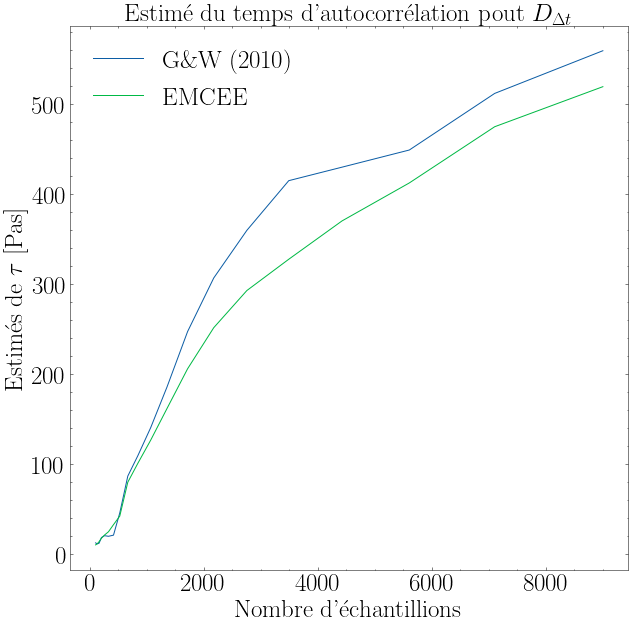

In [51]:
window=8000
#autocorrelation function
# f = np.array([autocorr_func_1d(special_list[50 * 100 + i::100, 3], norm=True)[: window + 1] for i in range(100)])
chains = np.row_stack([special_list[50 * 100 + i::100, -1] for i in range(100)])

# Compute the estimators for a few different chain lengths
N = np.exp(np.linspace(np.log(100), np.log(9000), 20)).astype(int)
gw2010 = np.empty(len(N))
new = np.empty(len(N))
for i, n in enumerate(N):
    gw2010[i] = autocorr_gw2010(chains[:, :n])
    new[i] = autocorr_new(chains[:, :n])
plt.plot(N, gw2010, label="G\&W (2010)")
plt.plot(N, new, label="EMCEE")
plt.ylabel(r"Estimés de $\tau$ [Pas]")
plt.xlabel("Nombre d'échantillions")
plt.title("Estimé du temps d'autocorrélation pout $D_{\Delta t}$")
plt.legend()

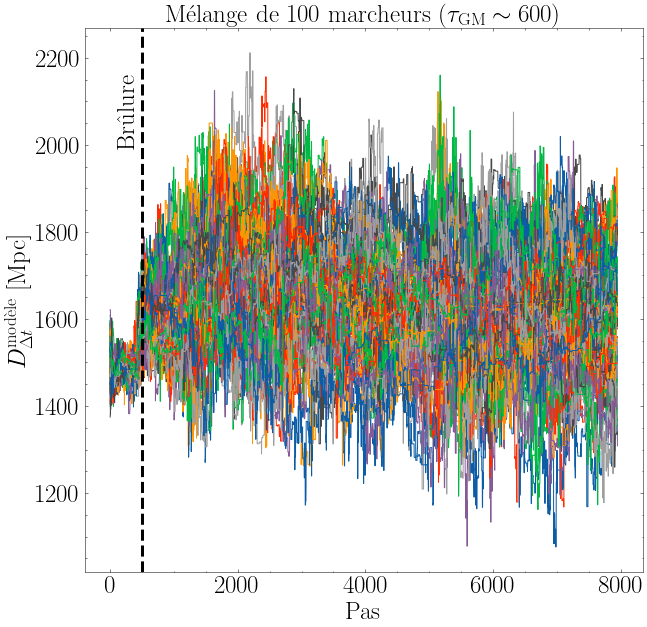

<Figure size 720x720 with 0 Axes>

In [52]:
params = {'legend.fontsize': '25',
          'figure.figsize': (10, 10),
         'axes.labelsize': '25',
         'axes.titlesize':'25',
         'xtick.labelsize':'25',
         'ytick.labelsize':'25'}
pylab.rcParams.update(params)
plt.figure()
for i in range(100):
    plt.plot(special_list[100 * 50 + i::100, -1]);
plt.axvline(500, color="k", ls="--", lw=3)
plt.title(r"Mélange de 100 marcheurs ($\tau_{\mathrm{GM}} \sim %.0f$)" % (np.around(gw2010[-1], -2)))
plt.annotate("Brûlure", xy=(100, 2000), rotation=90, fontsize=25)
plt.ylabel(r"$D_{\Delta t}^{\text{modèle}}$ [Mpc]")
plt.xlabel("Pas")
plt.savefig("../latex/final_report/figures/ddt_walkers_mixing.png")
plt.show()
plt.clf();

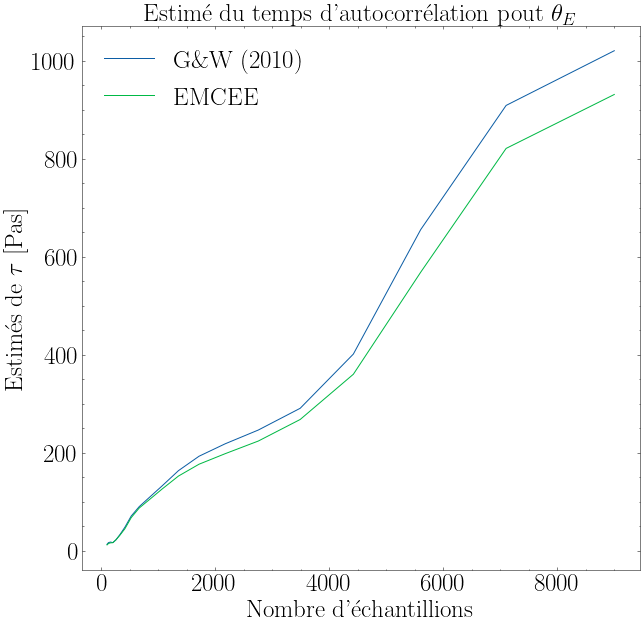

In [53]:
chains = np.row_stack([lens_params_new_list[50 * 100 + i::100, 0] for i in range(100)])

# Compute the estimators for a few different chain lengths
N = np.exp(np.linspace(np.log(100), np.log(9000), 20)).astype(int)
gw2010 = np.empty(len(N))
new = np.empty(len(N))
for i, n in enumerate(N):
    gw2010[i] = autocorr_gw2010(chains[:, :n])
    new[i] = autocorr_new(chains[:, :n])
plt.plot(N, gw2010, label="G\&W (2010)")
plt.plot(N, new, label="EMCEE")
plt.ylabel(r"Estimés de $\tau$ [Pas]")
plt.xlabel("Nombre d'échantillions")
plt.title(r"Estimé du temps d'autocorrélation pout $\theta_E$")
plt.legend()

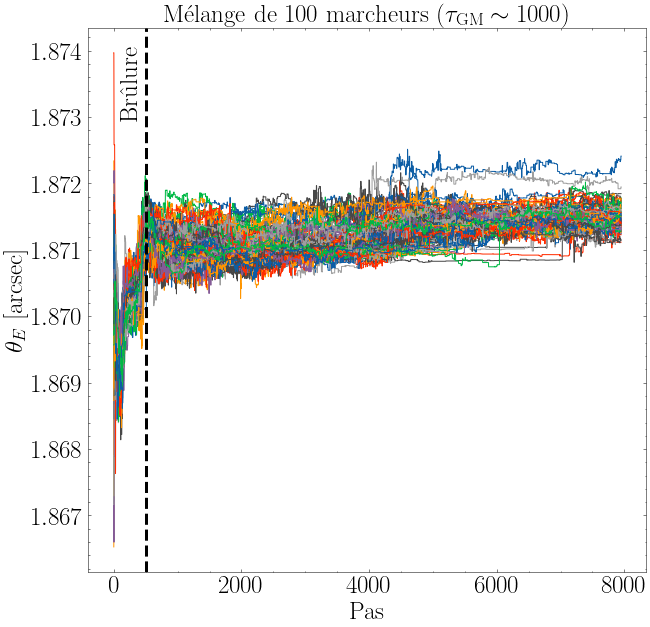

<Figure size 720x720 with 0 Axes>

In [54]:
params = {'legend.fontsize': '25',
          'figure.figsize': (10, 10),
         'axes.labelsize': '25',
         'axes.titlesize':'25',
         'xtick.labelsize':'25',
         'ytick.labelsize':'25'}
pylab.rcParams.update(params)
plt.figure()
for i in range(100):
    plt.plot(lens_params_new_list[50 * 100 + i::100, 0]);
plt.axvline(500, color="k", ls="--", lw=3)
plt.title(r"Mélange de 100 marcheurs ($\tau_{\mathrm{GM}} \sim%.0f$)" % (np.around(gw2010[-1], -2)))
plt.annotate("Brûlure", xy=(100, 1.873), rotation=90, fontsize=25)
plt.ylabel(r"$\theta_{E}$ [arcsec]")
plt.xlabel("Pas")
plt.savefig("../figures/thetaE_walkers_mixing.png")
plt.show()
plt.clf();

/home/alexandre/anaconda3/lib/python3.8/site-packages/matplotlib/text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


Text(0.5, 1.0, '[0.49983335 0.50419899 0.50827093]')

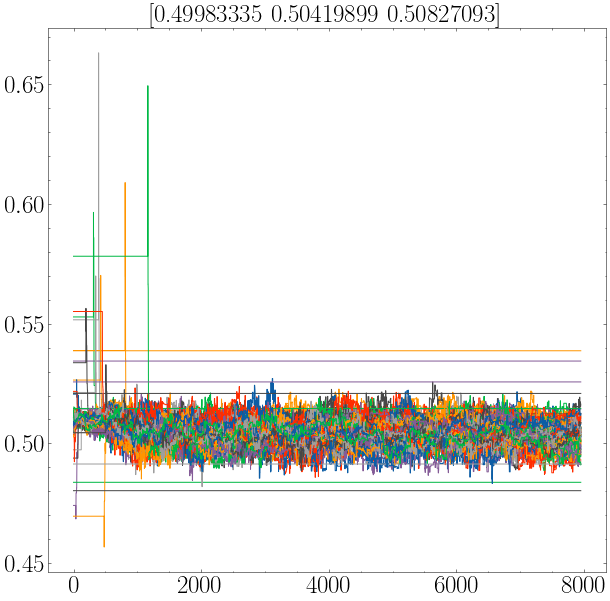

In [55]:
plt.figure()
for i in range(100):
    plt.plot(point_source_new_list[50 * 100 + i::100, -2] - x_center);
plt.title(np.quantile(point_source_new_list[50 * 100 + i::100, -2] - x_center, [0.16, 0.5, 0.84]))

/home/alexandre/anaconda3/lib/python3.8/site-packages/matplotlib/text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


Text(0.5, 1.0, '[-0.18390083 -0.18285619 -0.18184932]')

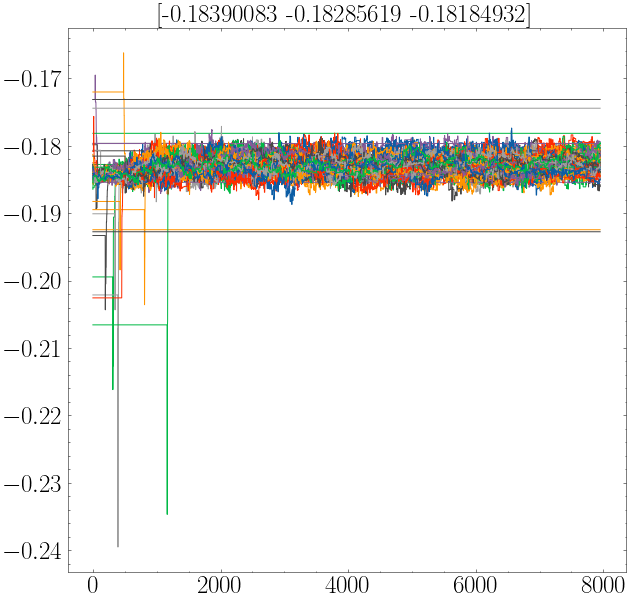

In [56]:
plt.figure()
for i in range(100):
    plt.plot(point_source_new_list[50 * 100 + i::100, -1] - y_center);
plt.title(np.quantile(point_source_new_list[50 * 100 + i::100, -1] - y_center, [0.16, 0.5, 0.84]))

<Figure size 720x720 with 0 Axes>

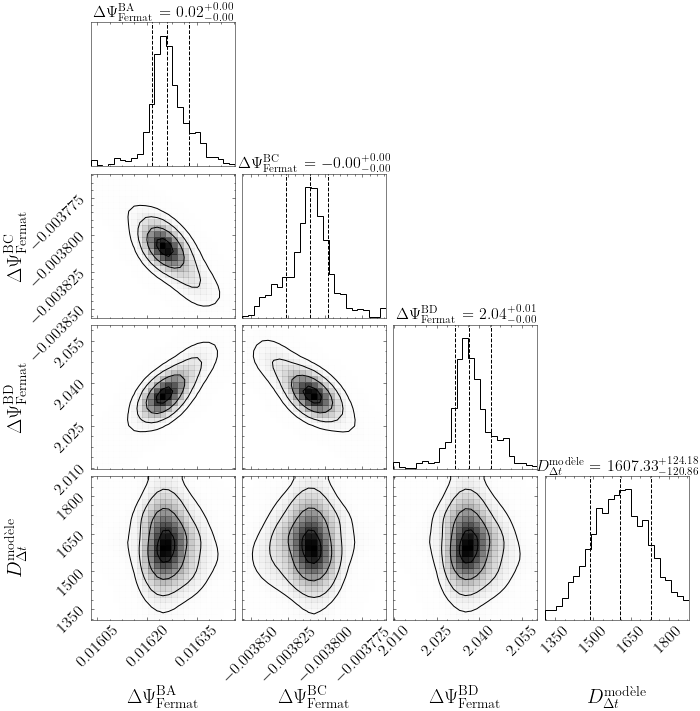

<Figure size 720x720 with 0 Axes>

In [57]:
burn_in = 6000
params = {'legend.fontsize': '25',
          'figure.figsize': (10, 10),
         'axes.labelsize': '20',
         'axes.titlesize':'16',
         'xtick.labelsize':'16',
         'ytick.labelsize':'16'}
pylab.rcParams.update(params)
plt.figure(figsize=(10, 10))
scaling = np.array([-1, -1, -1, 1])
plot = corner.corner(special_list[100 * burn_in:, :] * scaling, labels=labels_special, show_titles=True, title_fmt=".2f", quantiles=[0.16, 0.5, 0.84], 
                    plot_datapoints=False, range=[0.98]*4, max_n_ticks=4, labelpad=0.15, bins=25, smooth=2)
plt.savefig("../latex/final_report/figures/special_corner.png")
plt.show()
plt.clf();

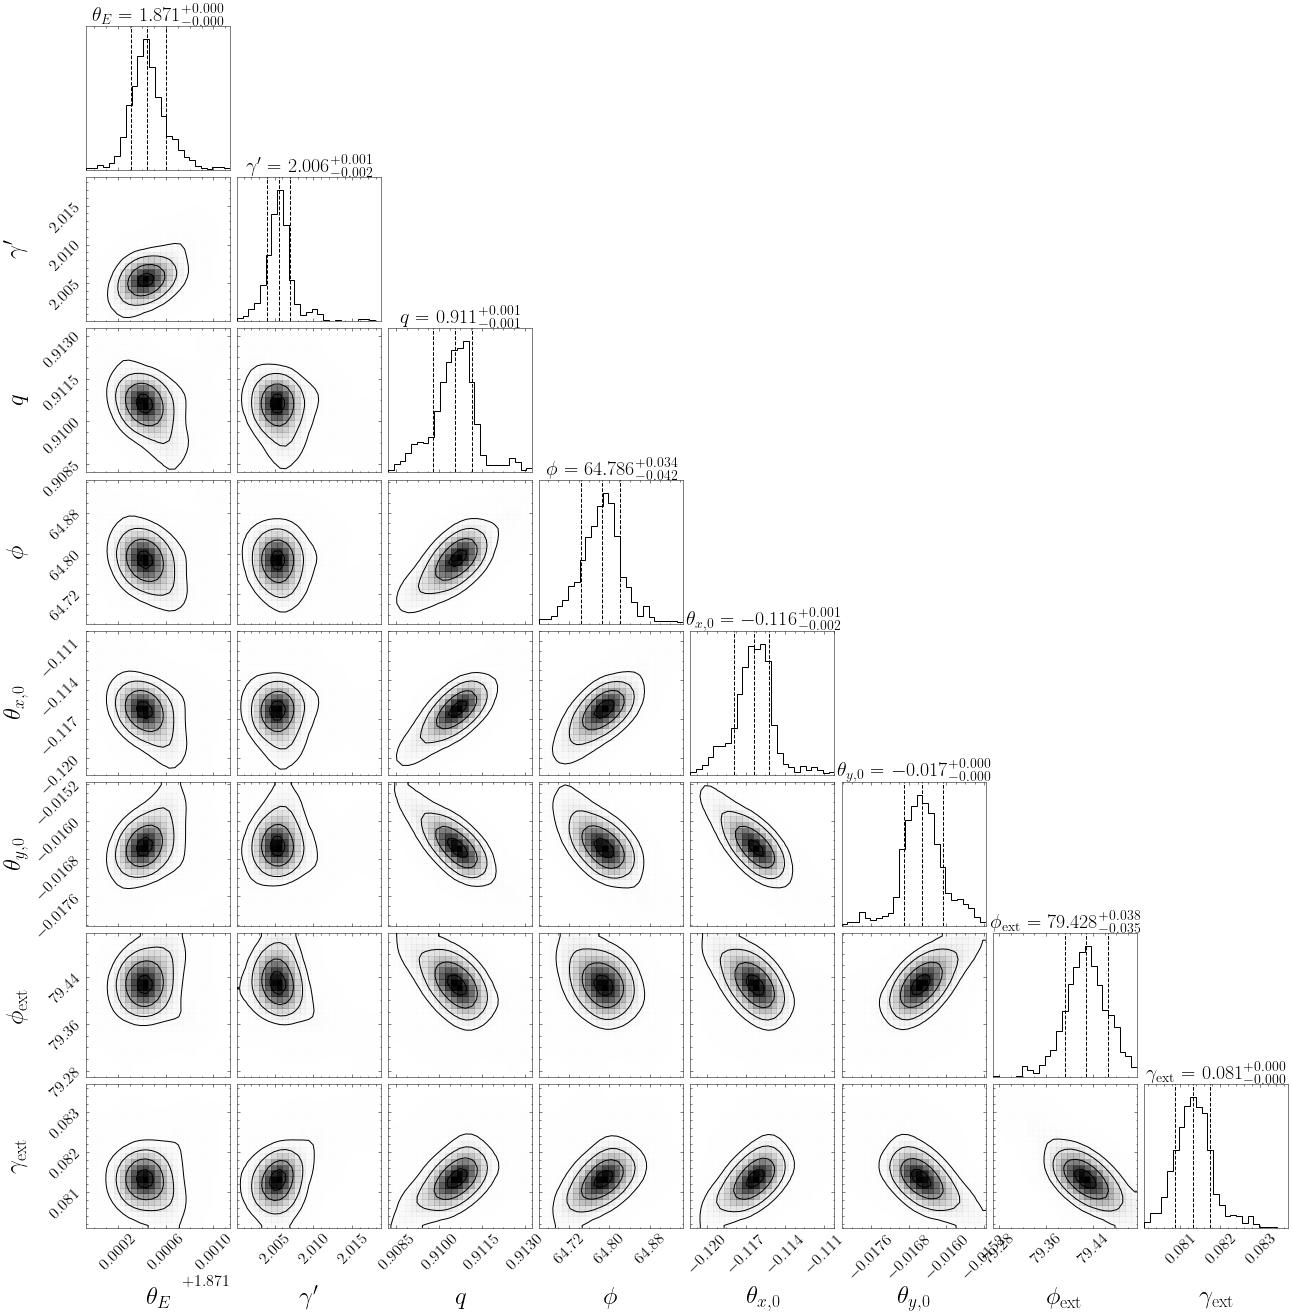

<Figure size 720x720 with 0 Axes>

In [87]:
params = {'legend.fontsize': '25',
          'figure.figsize': (10, 10),
         'axes.labelsize': '25',
         'axes.titlesize':'20',
         'xtick.labelsize':'16',
         'ytick.labelsize':'16'}
pylab.rcParams.update(params)

scaling = np.ones(lens_params_new_list[100*burn_in:, :].shape[1])
scaling[[3, 6]] *= 180 / np.pi


burn_in = 6000
ndim = lens_params_new_list.shape[1]
offset = np.array([0, 0, 0, 0, x_center, y_center, 0, 0])
plot = corner.corner(lens_params_new_list[100*burn_in:, :] * scaling - offset, labels=lens_labels, show_titles=True, quantiles=[0.16, 0.5, 0.84], title_fmt=".3f", 
                     plot_datapoints=False, range=[0.98]*ndim, max_n_ticks=4, labelpad=0.1, bins=25, smooth=2)
axes = np.array(plot.axes).reshape((ndim, ndim))

# # Loop over the diagonal
# for i in range(ndim):
#     ax = axes[i, i]
#     low, med, high = np.quantile(lens_params_new_list[100*burn_in:, i], [0.16, 0.5, 0.84])
#     if i in []
#     title
    
# # Loop over the histograms
# for yi in range(ndim):
#     for xi in range(yi):
#         ax = axes[yi, xi]
#         ax.axvline(value1[xi], color="g")
#         ax.axvline(value2[xi], color="r")
#         ax.axhline(value1[yi], color="g")
#         ax.axhline(value2[yi], color="r")
#         ax.plot(value1[xi], value1[yi], "sg")
#         ax.plot(value2[xi], value2[yi], "sr")

plt.savefig("../latex/final_report/figures/lens_params_corner_plot.png")
plt.show()
plt.clf();

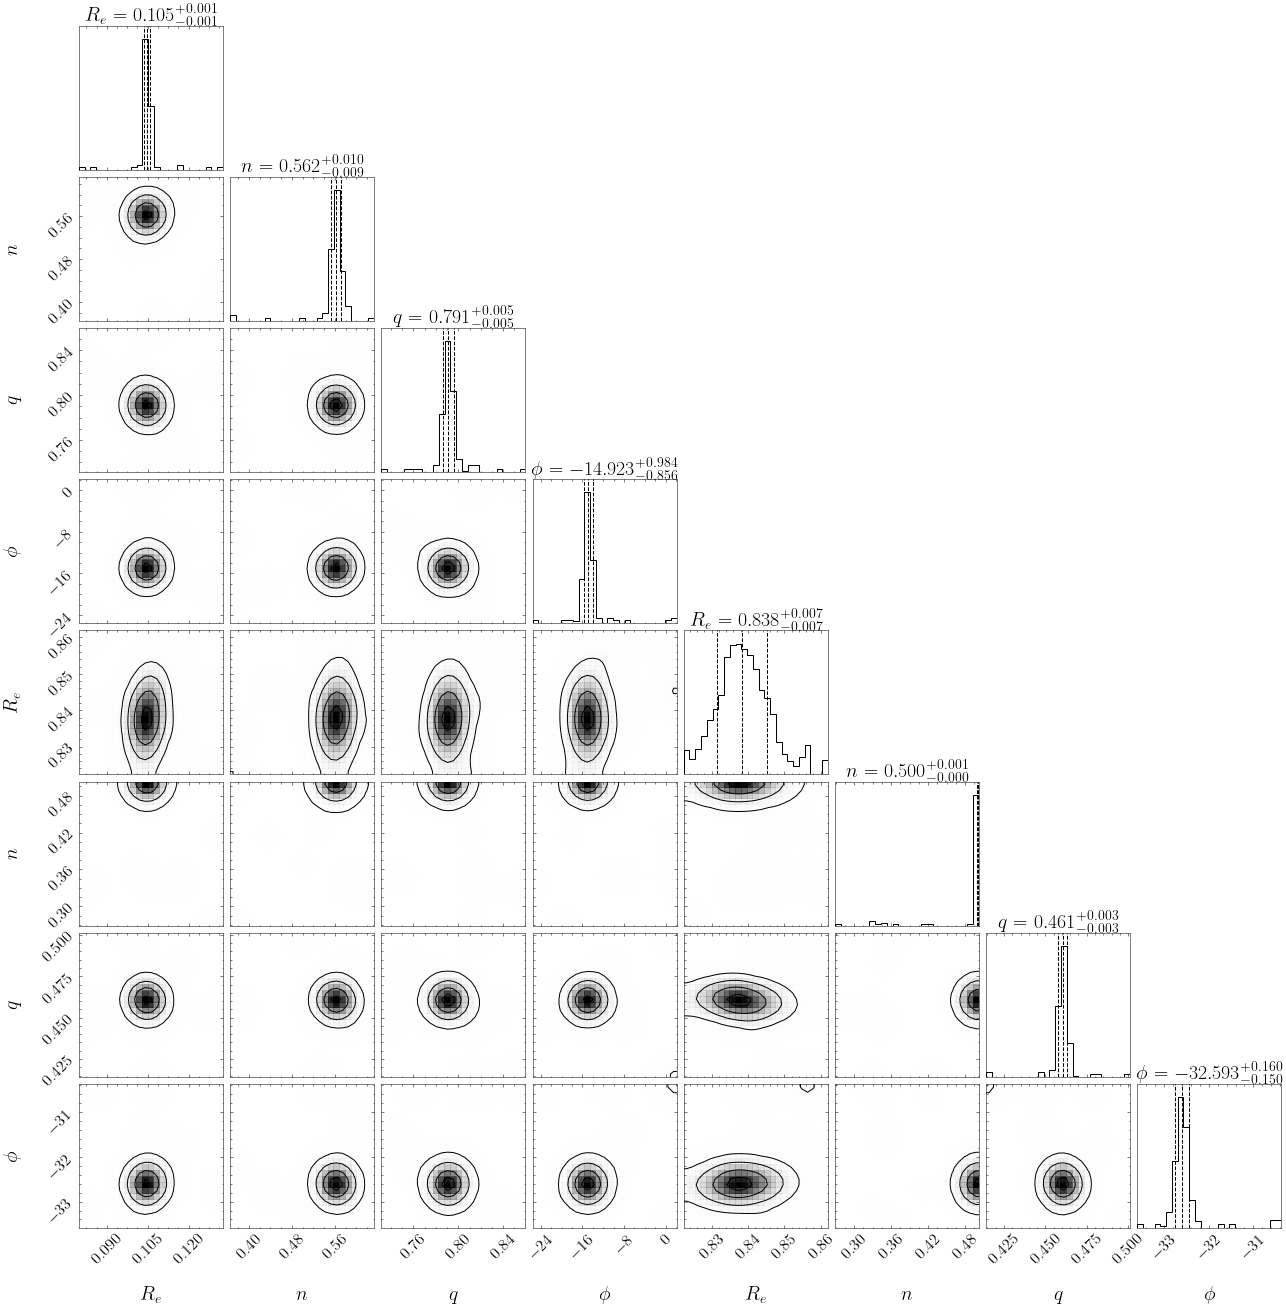

<Figure size 720x720 with 0 Axes>

In [69]:
scaling = np.ones(source_params_new_list[100*burn_in:, :].shape[1])
scaling[[3, 7]] *= 180 / np.pi


burn_in = 4000
ndim = lens_params_new_list.shape[1]
# offset = np.array([0, 0, 0, 0, x_center, y_center, 0, 0])
plot = corner.corner(source_params_new_list[100*burn_in:, :]*scaling, labels=source_labels*2, show_titles=True, quantiles=[0.16, 0.5, 0.84], title_fmt=".3f", 
                     plot_datapoints=False, range=[0.98]*ndim, max_n_ticks=4, labelpad=0.1, bins=25, smooth=2)
axes = np.array(plot.axes).reshape((ndim, ndim))

# # Loop over the diagonal
# for i in range(ndim):
#     ax = axes[i, i]
#     low, med, high = np.quantile(lens_params_new_list[100*burn_in:, i], [0.16, 0.5, 0.84])
#     if i in []
#     title
    
# # Loop over the histograms
# for yi in range(ndim):
#     for xi in range(yi):
#         ax = axes[yi, xi]
#         ax.axvline(value1[xi], color="g")
#         ax.axvline(value2[xi], color="r")
#         ax.axhline(value1[yi], color="g")
#         ax.axhline(value2[yi], color="r")
#         ax.plot(value1[xi], value1[yi], "sg")
#         ax.plot(value2[xi], value2[yi], "sr")

# plt.savefig("../latex/final_report/figures/lens_params_corner_plot.png")
plt.show()
plt.clf();

In [81]:
def weighted_quantile(values, quantiles, sample_weight=None, 
                      values_sorted=False, old_style=False):
    """ Very close to numpy.percentile, but supports weights.
    NOTE: quantiles should be in [0, 1]!
    :param values: numpy.array with data
    :param quantiles: array-like with many quantiles needed
    :param sample_weight: array-like of the same length as `array`
    :param values_sorted: bool, if True, then will avoid sorting of
        initial array
    :param old_style: if True, will correct output to be consistent
        with numpy.percentile.
    :return: numpy.array with computed quantiles.
    """
    values = np.array(values)
    quantiles = np.array(quantiles)
    if sample_weight is None:
        sample_weight = np.ones(len(values))
    sample_weight = np.array(sample_weight)
    assert np.all(quantiles >= 0) and np.all(quantiles <= 1), \
        'quantiles should be in [0, 1]'

    if not values_sorted:
        sorter = np.argsort(values)
        values = values[sorter]
        sample_weight = sample_weight[sorter]

    weighted_quantiles = np.cumsum(sample_weight) - 0.5 * sample_weight
    if old_style:
        # To be convenient with numpy.percentile
        weighted_quantiles -= weighted_quantiles[0]
        weighted_quantiles /= weighted_quantiles[-1]
    else:
        weighted_quantiles /= np.sum(sample_weight)
    return np.interp(quantiles, weighted_quantiles, values)

In [82]:
params = {'legend.fontsize': '25',
          'figure.figsize': (10, 10),
         'axes.labelsize': '25',
         'axes.titlesize':'25',
         'xtick.labelsize':'25',
         'ytick.labelsize':'25'}
pylab.rcParams.update(params)

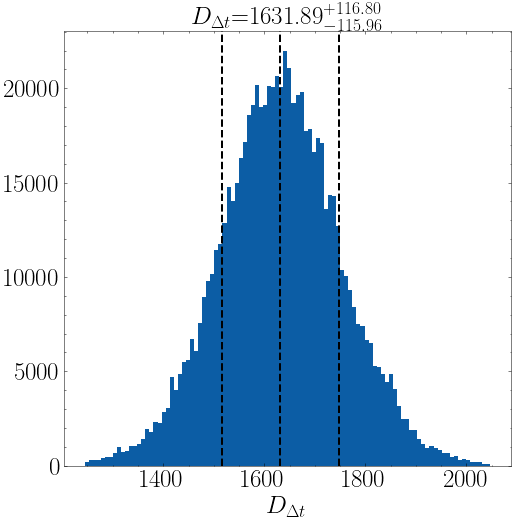

In [83]:
Ddt = special_list[100*500:, -1]

low, ql, med, qh, high = weighted_quantile(Ddt, [0.001, 0.16, 0.5, 0.84, 0.999])
error_plus = qh - med
error_minus = med - ql
good = (Ddt > low) & (Ddt < high)
Ddt = Ddt[good]

plt.figure(figsize=(8, 8))
plt.hist(Ddt, bins=100);
plt.title(r"$D_{\Delta t}$=%.2f$^{+%.2f}_{-%.2f}$" % (med, error_plus, error_minus))
plt.xlabel(r"$D_{\Delta t}$");
plt.axvline(med, color="k", ls="--", lw=2)
plt.axvline(qh, color="k", ls="--", lw=2)
plt.axvline(ql, color="k", ls="--", lw=2)
# plt.savefig("../latex/beamer_lens/figures/marginalized_posterior_Ddt.png")

Text(0.5, 0, '$H_0$ [km s$^{-1}$ Mpc$^{-1}$]')

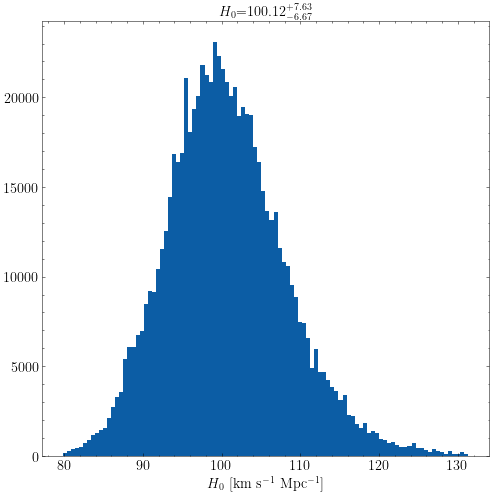

In [95]:

z_lens = 0.295
z_source = 0.654
omega_m = 0.3
omega_L = 0.7
def H(z):
    return 1/np.sqrt(omega_m * (1 + z)**3 + omega_L)
Dd = quad(H, 0, z_lens)[0]/(1 + z_lens)
Ds = quad(H, 0, z_source)[0]/(1 + z_source)
Dds = quad(H, z_lens, z_source)[0]/(1 + z_source)
factor = (1 + z_lens) * Ds * Dd / Dds
H0 = (c * factor / Ddt / u.Mpc).to(u.km / u.s / u.Mpc).value
plt.figure(figsize=(8, 8))
ql, med, qh = weighted_quantile(H0, [ 0.16, 0.5, 0.84])
error_plus = qh - med
error_minus = med - ql
plt.hist(H0, bins=100)
plt.title(r"$H_0$=%.2f$^{+%.2f}_{-%.2f}$" % (med, error_plus, error_minus))
plt.xlabel(r"$H_0$ [km s$^{-1}$ Mpc$^{-1}$]")
# plt.savefig("../latex/beamer_lens/figures/marginalized_posterior_H0.png")

In [323]:
%%script false --no-raise-error
# reiterate mcmc near maximum for a longer time to allow for ergodicity
init_samples = np.median(chain_list[1][1], axis=0, keepdims=True)
spread = np.std(chain_list[1][1], axis=0, keepdims=True) * 0.5 # very small spread
init_samples = np.random.normal(loc=init_samples, scale=spread, size=[1000, 20]) # sample a polulation near the median
mcmc_kwargs = {'n_burn': 0, 'n_run': 10000, 'walkerRatio': 5, "init_samples": init_samples} # the mcmc will start from its previous position
new_chain_list = fitting_seq.mcmc(**mcmc_kwargs)

In [324]:
%%script false --no-raise-error

sampler_type, samples_mcmc, param_mcmc, dist_mcmc  = new_chain_list

print("number of non-linear parameters in the MCMC process: ", len(param_mcmc))
print("parameters in order: ", param_mcmc)
print("number of evaluations in the MCMC process: ", np.shape(samples_mcmc)[0])

# make instance of parameter class with given model options, constraints and fixed parameters #

param = Param(kwargs_model, fixed_lens, None, fixed_source, fixed_ps, fixed_special, 
              kwargs_lens_init=kwargs_result['kwargs_lens'], **kwargs_constraints)
# the number of non-linear parameters and their names #
num_param, param_list = param.num_param()

lens_params_new_list = []
special_list = []
source_params_new_list = []

# labels_new = [r"$\phi_{Fermat}$", r"$\gamma_1$", r"$\gamma_2$", r"$D_{\Delta t}$"]
for i in tqdm(range(len(samples_mcmc))):
    # transform the parameter position of the MCMC chain in a lenstronomy convention with keyword arguments #
    kwargs_result = param.args2kwargs(samples_mcmc[i])
    
    #special
    D_dt = kwargs_result['kwargs_special']['D_dt']
    fermat_pot = td_cosmo.fermat_potential(kwargs_result['kwargs_lens'], kwargs_result['kwargs_ps'])
    delta_fermat_BA = fermat_pot[0] - fermat_pot[1]
    delta_fermat_BC = fermat_pot[0] - fermat_pot[2]
    delta_fermat_BD = fermat_pot[0] - fermat_pot[3]
    special_list.append([delta_fermat_BA, delta_fermat_BC, delta_fermat_BD, D_dt])

    # Lens
    gamma1, gamma2 = kwargs_result['kwargs_lens'][1]['gamma1'], kwargs_result['kwargs_lens'][1]['gamma2']
    gamma_ext, phi_ext = param_util.shear_cartesian2polar(gamma1, gamma2)
    gamma = kwargs_result["kwargs_lens"][0]["gamma"]
    theta_E = kwargs_result["kwargs_lens"][0]["theta_E"]
    e1, e2 = kwargs_result["kwargs_lens"][0]["e2"], kwargs_result["kwargs_lens"][0]["e1"]
    phi, q = param_util.ellipticity2phi_q(e1, e2)
    x0, y0 = kwargs_result["kwargs_lens"][0]["center_x"], kwargs_result["kwargs_lens"][0]["center_y"]
    mcmc_new_list.append([delta_fermat_12, gamma1, gamma2, D_dt])
    lens_params_new_list.append([theta_E, gamma, q, phi, x0, y0, gamma_ext, phi_ext])
    
    # Source (Disk = 0, Bulb = 1)
    R_disc = kwargs_result['kwargs_source'][0]["R_sersic"]
    n_disc = kwargs_result['kwargs_source'][0]["n_sersic"]
    e1, e2 = kwargs_result['kwargs_source'][0]["e1"], kwargs_result['kwargs_source'][0]["e2"]
    phi_disc, q_disc = param_util.ellipticity2phi_q(e1, e2)

    R_bulb = kwargs_result['kwargs_source'][1]["R_sersic"]
    n_bulb = kwargs_result['kwargs_source'][1]["n_sersic"]
    e1, e2 = kwargs_result['kwargs_source'][1]["e1"], kwargs_result['kwargs_source'][1]["e2"]
    phi_bulb, q_bulb = param_util.ellipticity2phi_q(e1, e2)
    source_params_new_list.append([R_disc, n_disc, q_disc, phi_disc, R_bulb, n_bulb, q_bulb, phi_bulb])



In [325]:
burn_in=7000

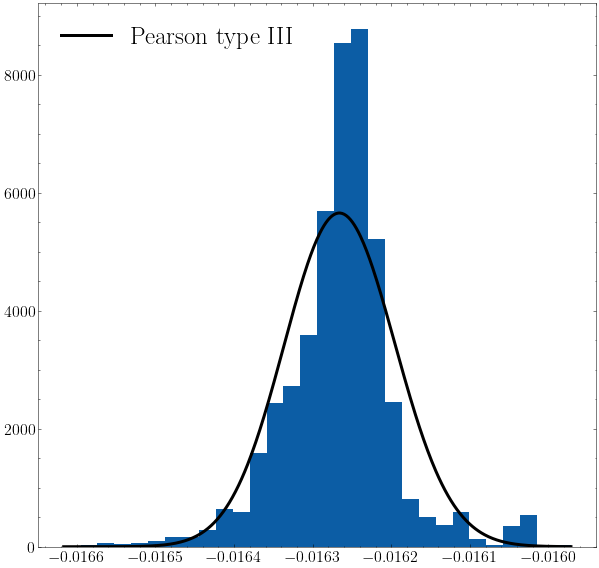

In [326]:
phi_ab = special_list[100*burn_in:, 0]
phi_ab_mean = phi_ab.mean()
phi_ab_std = phi_ab.std()
phi_ab_skew = skew(phi_ab)
x = np.linspace(phi_ab.min(), phi_ab.max(), 500)
plt.hist(phi_ab, bins=30, density=True);
plt.plot(x, pearson3.pdf(x, skew=phi_ab_skew, loc=phi_ab_mean, scale=phi_ab_std), color="k", lw=3, label="Pearson type III")
plt.legend()

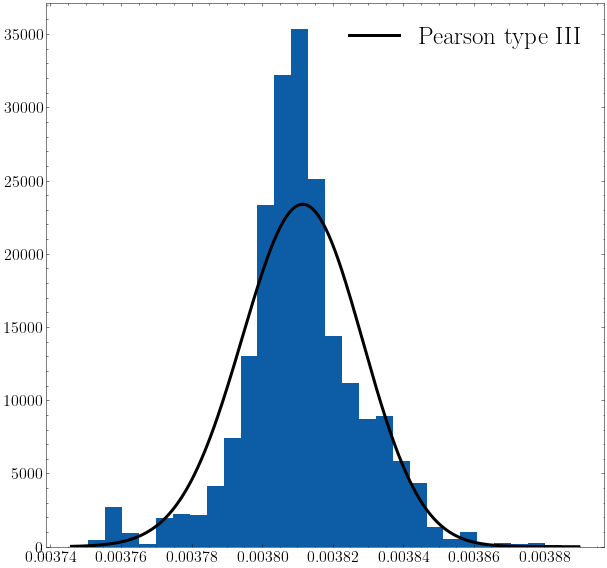

In [327]:
phi_bc = special_list[100*burn_in:, 1]
phi_bc_mean = phi_bc.mean()
phi_bc_std = phi_bc.std()
phi_bc_skew = skew(phi_bc)
x = np.linspace(phi_bc.min(), phi_bc.max(), 500)
plt.hist(phi_bc, bins=30, density=True);
# plt.axvline(phi_bc_mean)
plt.plot(x, pearson3.pdf(x, skew=phi_bc_skew, loc=phi_bc_mean, scale=phi_bc_std), color="k", lw=3, label="Pearson type III")
plt.legend()

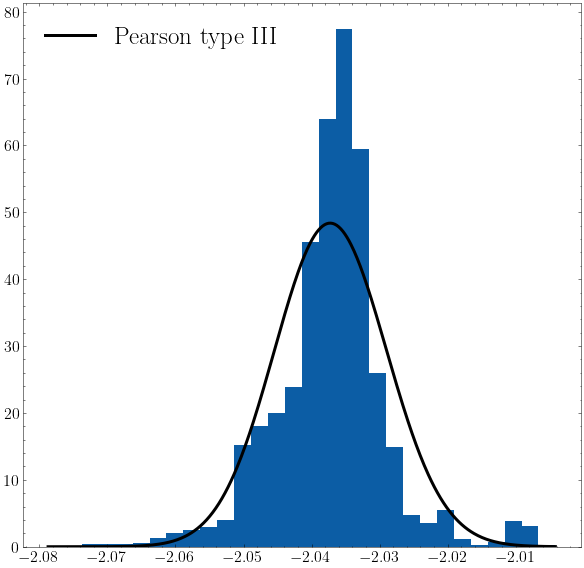

In [328]:
phi_bd = special_list[100*burn_in:, 2]
phi_bd_mean = phi_bd.mean()
phi_bd_std = phi_bd.std()
phi_bd_skew = skew(phi_bd)
x = np.linspace(phi_bd.min(), phi_bd.max(), 500)
plt.hist(phi_bd, bins=30, density=True);
# plt.axvline(phi_bc_mean)
plt.plot(x, pearson3.pdf(x, skew=phi_bd_skew, loc=phi_bd_mean, scale=phi_bd_std), color="k", lw=3, label="Pearson type III")
plt.legend()

In [166]:
potential_out = np.array([
    [phi_ab_mean, phi_ab_std, phi_ab_skew],
    [phi_bc_mean, phi_bc_std, phi_bc_skew],
    [phi_bd_mean, phi_bd_std, phi_bd_skew],
])
np.savetxt("../results/potential_moments_may1_17_04.txt", potential_out, header="0=BA, 1=BC, 2=BD")
potential_out

array([[-1.62646948e-02,  7.05079097e-05,  3.85226578e-02],
       [ 3.81092646e-03,  1.70704712e-05, -6.73712795e-02],
       [-2.03712646e+00,  8.24536536e-03,  3.33402678e-02]])

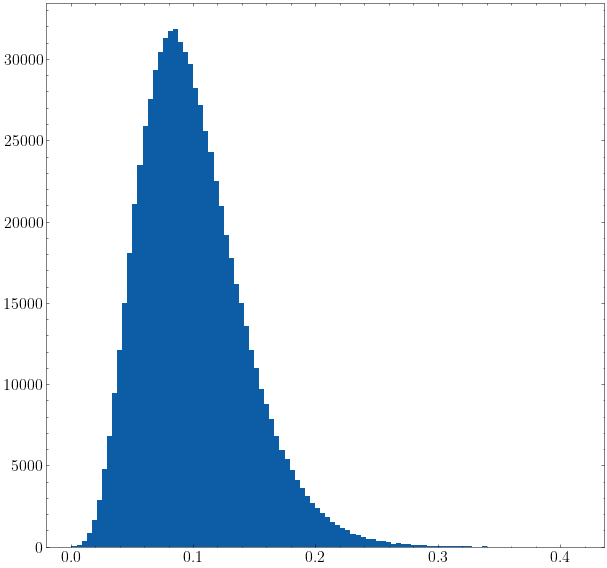

In [262]:
mu_kappa = 0.1
std_kappa = 0.042
skew_kappa = 0.8

kappa_population = pearson3.rvs(skew_kappa, mu_kappa, std_kappa, size=Ddt.size)
plt.hist(kappa_population, bins=100);

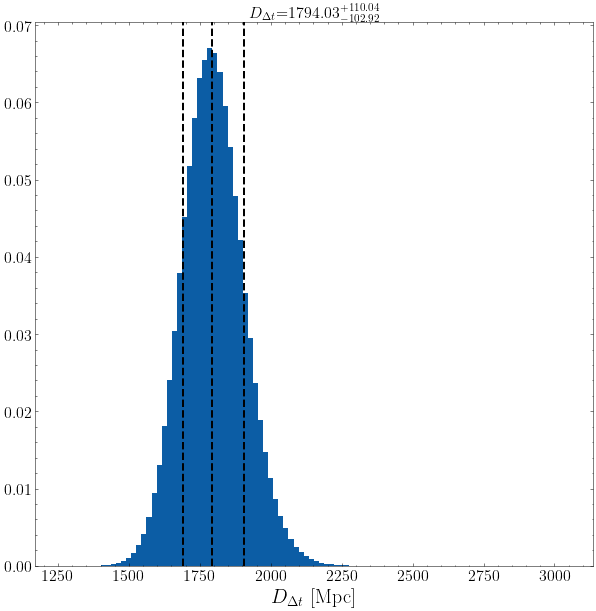

In [473]:
mean_ddt = Ddt.mean()
std_ddt = Ddt.std()
skew_ddt = skew(Ddt)
# ddt_posterior = 1/np.sqrt(2 * np.pi) /std_ddt * np.exp(-0.5 * (Ddt - mean_ddt)**2 / std_ddt**2)
ddt_posterior = pearson3.pdf(Ddt, loc=mean_ddt, scale=std_ddt, skew=skew_ddt)

true_ddt = Ddt / (1 - kappa_population)
weights = ddt_posterior * pearson3.pdf(kappa_population, loc=mu_kappa, scale=std_kappa, skew=skew_kappa)
weights /= weights.sum()

ql, med, qh = weighted_quantile(true_ddt, [0.16, 0.5, 0.84], weights)
error_plus = qh - med
error_minus = med - ql


plt.title(r"$D_{\Delta t}$=%.2f$^{+%.2f}_{-%.2f}$" % (med, error_plus, error_minus))
plt.xlabel(r"$D_{\Delta t}$ [Mpc]");
# plt.title(r"$H_0$=%.2f$^{+%.2f}_{-%.2f}$" % (med, error_plus, error_minus))
# plt.xlabel(r"$H_0$ [km s$^{-1}$ Mpc$^{-1}$]")
plt.hist(true_ddt, bins=100, weights=weights);
plt.axvline(med, color="k", ls="--", lw=2)
plt.axvline(qh, color="k", ls="--", lw=2)
plt.axvline(ql, color="k", ls="--", lw=2)
plt.savefig("../latex/final_report/figures/ddt_posterior.png")

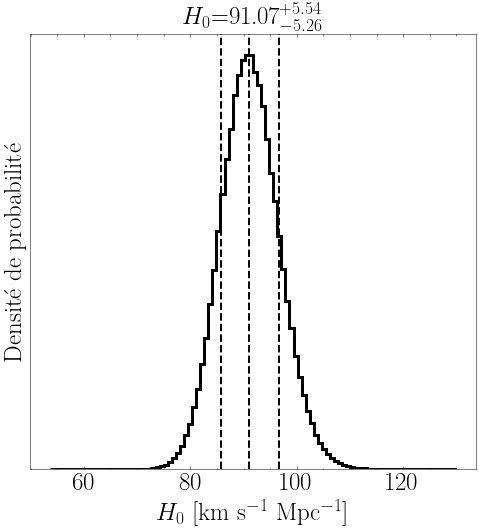

In [491]:
z_lens = 0.295
z_source = 0.654
omega_m = 0.3
omega_L = 0.7
def H(z):
    return 1/np.sqrt(omega_m * (1 + z)**3 + omega_L)
Dd = quad(H, 0, z_lens)[0]/(1 + z_lens)
Ds = quad(H, 0, z_source)[0]/(1 + z_source)
Dds = quad(H, z_lens, z_source)[0]/(1 + z_source)
factor = (1 + z_lens) * Ds * Dd / Dds
H0 = (c * factor / true_ddt / u.Mpc).to(u.km / u.s / u.Mpc).value
plt.figure(figsize=(8, 8))
ql, med, qh = weighted_quantile(H0, [0.16, 0.5, 0.84], weights)
error_plus = qh - med
error_minus = med - ql
plt.hist(H0, bins=100, weights=weights, histtype="step", color="k", lw=3)
plt.title(r"$H_0$=%.2f$^{+%.2f}_{-%.2f}$" % (med, error_plus, error_minus), pad=10)
plt.axvline(med, color="k", ls="--", lw=2)
plt.axvline(qh, color="k", ls="--", lw=2)
plt.axvline(ql, color="k", ls="--", lw=2)
plt.xlabel(r"$H_0$ [km s$^{-1}$ Mpc$^{-1}$]")
plt.yticks([], [])
plt.ylabel("Densité de probabilité")
plt.savefig("../latex/final_report/figures/H0_posterior.png")